In this notebook, we will introduce how to analyze cryptic allosteric sites in a trajectory. 

Please make sure you are running the notebook at the directory of "DASH/tutorial/04_Ana_Allo_Sites", because we will use relative path in this notebook. 

-----------------------------------------------------------------------------------------------------------------------------------------

First, let's generate a short simulation data of apo RORγt as example.

In [ ]:
import os
os.system("../../bin/DASH -i rorc.in")

In RORγt, there is a cryptic allosteric site in its C-terminal. We will analyze the openness of this pocket during simulation. 

Make sure fpocket4 is in your environment

mkdir: cannot create directory ‘ebpgMD_SplitContrastMAE_CA_rorc_apo_rt10_nsd20_fcp01000_ecsol_msr0_pct20l10/0/pocket_exposure’: File exists


rorc: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


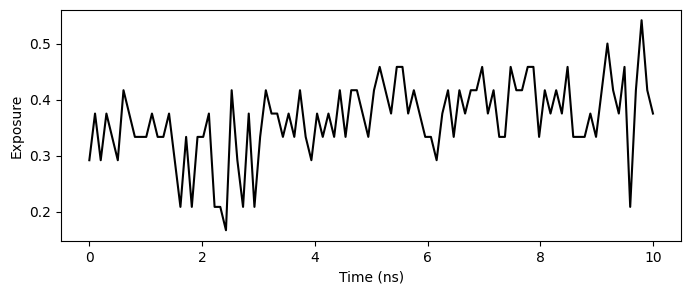

In [6]:
import os
import prody
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

def get_ref_atoms_by_fpocket(pdb_file,workdir,lig_sel,save_label="ref_atoms",return_all=False):
    here = os.getcwd()
    pdb_file_main = pdb_file.split("/")[-1]
    name = pdb_file_main.split(".pdb")[0]
    if os.path.exists("%s/%s_%s.npy"%(workdir,name,save_label)):
        return np.load("%s/%s_%s.npy"%(workdir,name,save_label),allow_pickle=True).item()
    os.chdir(workdir)
    prody.writePDB(pdb_file_main,prody.parsePDB(pdb_file).select('not name "H.*"').copy())
    if not os.path.exists("%s_out"%(name)):
        os.popen("fpocket -f %s"%(pdb_file_main)).read()
    if not os.path.exists("%s_out/%s_info.txt"%(name,name)):
        os.chdir(here)
        return []
    f = open("%s_out/%s_info.txt"%(name,name))
    fli = f.read().split("\n\n")
    f.close()
    p = prody.parsePDB(pdb_file_main)
    d_id = 1 - p.select("protein and name CA").getResnums()[0]
    if return_all:
        atoms = [get_atoms(prody.parsePDB("%s_out/pockets/pocket%d_atm.pdb"%(name,i+1)),d_id) for i,data in enumerate(fli) if data != ""]
        os.chdir(here)
        return atoms
    lig_center = p.select(lig_sel).getCoords().mean(0)
    poc_infos = []
    for i,data in enumerate(fli):
        if data == "":
            continue
        poc_center = get_vert_infos("%s_out/pockets/pocket%d_vert.pqr"%(name,i+1))[0].mean(0)
        d = np.linalg.norm(poc_center-lig_center)
        poc_atoms = get_atoms(prody.parsePDB("%s_out/pockets/pocket%d_atm.pdb"%(name,i+1)),d_id)
        poc_infos.append([i,d,poc_atoms])
    poc_infos.sort(key=lambda x:x[1])
    os.chdir(here)
    np.save("%s/%s_%s.npy"%(workdir,name,save_label),poc_infos[0][2])
    return poc_infos[0][2]

def get_atoms(pdb,d_id=0):
    return set([(a.getResnum()+d_id,a.getName()) for a in pdb])

def get_vert_infos(file):
    f = open(file)
    fli = f.read().split("\n")
    f.close()
    coords = []
    rs = []
    for line in fli:
        if line[0:4] == "ATOM":
            coords.append([float(line[30:38]),float(line[38:46]),float(line[46:54])])
            rs.append(float(line.split()[-1]))
    return np.array(coords),np.array(rs)

def calc_overlap_score(main_set,ref_set,):
    n = 0
    for x in ref_set:
        if x in main_set:
            n += 1
    return n / len(ref_set)

def calc_pocs(pdb_file,coords,sel_str,k,cset_id,):
    p = prody.parsePDB(pdb_file).select(sel_str).copy()
    p.setCoords(coords)
    p = p.select('protein and not name "H.*"').copy()
    name = "%s_frame%d"%(k,cset_id)
    conf_pdb_file = "%s_frame%d.pdb"%(k,cset_id)
    prody.writePDB(conf_pdb_file,p)
    os.popen("fpocket -f %s"%(conf_pdb_file)).read()

    if not os.path.exists("%s_out/%s_info.txt"%(name,name)):
        return 0
    f = open("%s_out/%s_info.txt"%(name,name))
    fli = f.read().split("\n\n")
    f.close()
    prop_dicts = []
    for i,data in enumerate(fli):
        if data == "":
            continue
        this_poc_dict = dict()
        for line in data.split("\n")[1:]:
            kk,v = line.split(":")
            this_poc_dict[kk.replace("\t","")] = float(v)
        poc = prody.parsePDB("%s_out/pockets/pocket%d_atm.pdb"%(name,i+1))
        poc_atoms = get_atoms(poc)
        this_poc_dict["poc_atoms"] = poc_atoms
        this_poc_dict["poc_atoms_coords"] = poc.getCoords()
        this_poc_dict["alpha_sphere_coords"],this_poc_dict["alpha_sphere_rs"] = get_vert_infos("%s_out/pockets/pocket%d_vert.pqr"%(name,i+1))
        prop_dicts.append(this_poc_dict)
    os.system("rm -rf %s_out"%(name))
    os.system("rm -rf %s.pdb"%(name))
    return prop_dicts

def mk_data(folder,k,n_proc=10,step=1):
    os.system("mkdir %s/pocket_exposure"%(folder))
    here = os.getcwd()
    os.chdir("%s/pocket_exposure"%(folder))
    cset = prody.parseDCD("../md_aligned.dcd",step=step).getCoordsets()
    pool = Pool(n_proc)
    ps = [pool.apply_async(calc_pocs,("../seed0.pdb",cset[i],"not resname WAT",k,i*step)) for i,c in enumerate(cset)]
    pool.close()
    results = [p.get() for p in tqdm(ps,k)]
    os.chdir(here)
    return results

def ana_exposure(data,ref_atoms,tmax=10):
    ref_res = set([a[0] for a in ref_atoms])
    exposure = [max([calc_overlap_score(set([a[0] for a in d2["poc_atoms"]]),ref_res) for d2 in d]) for i,d in enumerate(data)]
    x = np.linspace(0,10,len(exposure))
    plt.figure(figsize=(8,3))
    plt.plot(x,exposure,"-",color="black")
    plt.xlabel("Time (ns)")
    plt.ylabel("Exposure")
    plt.show()

    
if __name__ == "__main__":
    os.chdir("/home/jyzha/project/enhanced_sampling/DASH/tutorial/04_Ana_Allo_Sites/")
    k = "rorc"
    prop_dict = mk_data("ebpgMD_SplitContrastMAE_CA_rorc_apo_rt10_nsd20_fcp01000_ecsol_msr0_pct20l10/0","rorc",step=100,n_proc=10) #step could nbe samaller, but it takes longer time
    ref_atoms = get_ref_atoms_by_fpocket("4ypq_holo.pdb","rorc","resnum 601 and resname 4F1")
    ana_exposure(prop_dict,ref_atoms)
